In [107]:
#github link 
#This project is inspired by https://github.com/aqibsaeed/Urban-Sound-Classification/blob/master/Convolutional%20Neural%20Network.ipynb

In [5]:
# #Librosa is a library that is used for analyzing the behavior of audio
# !pip install librosa

In [8]:
#pip install tensorflow[and-cuda] #gast-0.4.0 keras-2.13.1 tensorboard-2.13.0 tensorflow-2.13.1 tensorflow-estimator-2.13.0

In [162]:
import glob, os, pickle
import librosa
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from tqdm import tqdm
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, confusion_matrix, auc
import matplotlib.pyplot as plt

import pandas as pd

import tensorflow as tf
import keras
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation,Flatten

import warnings
warnings.filterwarnings("ignore")

In [2]:
def extract_features(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.array(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=8).T)
    chroma = np.array(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T)
    mel = np.array(librosa.feature.melspectrogram(y=X, sr=sample_rate).T) #melspectrogram()
    contrast = np.array(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T)
    tonnetz = np.array(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T)
    return mfccs,chroma,mel,contrast,tonnetz


def parse_audio_files(parent_dir,sub_dirs,file_ext='*.wav'):
    ignored = []    
    for label, sub_dir in enumerate(sub_dirs):
        features, labels = np.empty((0,161)), np.empty(0)
        print(sub_dir)
        for fn in tqdm(glob.glob(os.path.join(parent_dir, sub_dir, file_ext))):            
            try:
                mfccs, chroma, mel, contrast, tonnetz = extract_features(fn)
                ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
                features = np.vstack([features,ext_features])
                l = [fn.split('-')[1]] * (mfccs.shape[0])
                labels = np.append(labels, l)
            except:
                print(f"{fn} is not proccessed.")
                ignored.append(file_ext)
                pass
            
    #pickle.dump((features, labels), open(f"./sound_pkl/{sub_dir}.pkl", "wb"))           
    return features, labels, ignored
    

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [87]:
import IPython.display as ipd
filepath = "./UrbanSound8K/audio/fold1/101415-3-0-2.wav"
ipd.Audio(filepath)

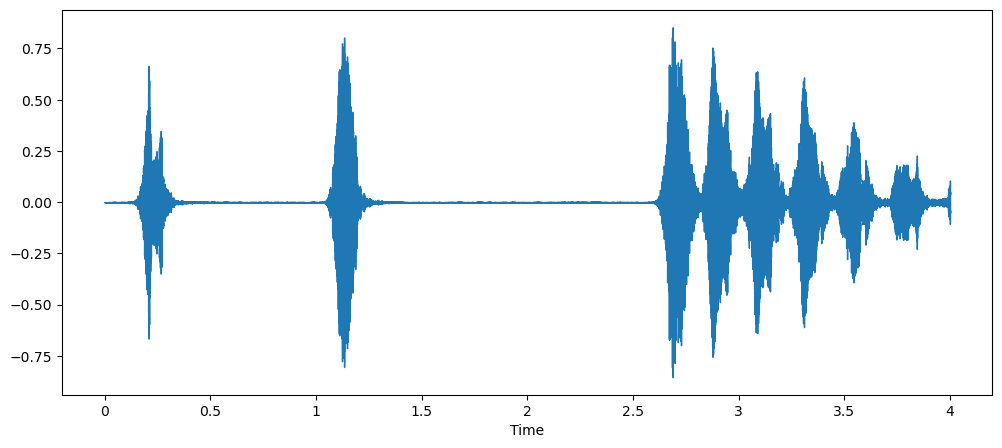

In [91]:
import librosa
import librosa.display
data, sample_rate = librosa.load(filepath)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(data, sr=sample_rate)

In [13]:
mfccs,chroma,mel,contrast,tonnetz = extract_features("./UrbanSound8K/audio/fold1/101415-3-0-2.wav")

In [9]:
mfccs.shape

(173, 8)

In [10]:
chroma.shape

(173, 12)

In [9]:
ext_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])

In [15]:
ext_features.shape

(173, 161)

In [16]:
features = np.empty((0,161))

In [17]:
features.shape

(0, 161)

In [19]:
features = np.vstack([features,ext_features])

In [20]:
features.shape

(173, 161)

In [9]:
parent_dir = 'UrbanSound8K/audio'

#add fold11 for snoring sound files, 800 random sample out of 3000 
sub_dirs = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']

In [10]:
file_ext='*.wav'

In [11]:
# try:
#     labels = np.load('labels.npy')
#     features = np.load('features.npy')
#     print("Features and labels found!")
# except:
print("Extracting features...")

features, labels, ignored = parse_audio_files(parent_dir,sub_dirs)

Extracting features...
fold1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 873/873 [03:30<00:00,  4.15it/s]


fold2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 888/888 [03:30<00:00,  4.21it/s]


fold3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 925/925 [03:46<00:00,  4.08it/s]


fold4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 990/990 [03:59<00:00,  4.13it/s]


fold5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 936/936 [03:43<00:00,  4.19it/s]


fold6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 823/823 [03:16<00:00,  4.19it/s]


fold7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 838/838 [03:23<00:00,  4.12it/s]


fold8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 806/806 [03:11<00:00,  4.22it/s]


fold9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 816/816 [03:17<00:00,  4.13it/s]


fold10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 837/837 [03:22<00:00,  4.14it/s]


In [12]:
# with open('features.npy', 'wb') as f1:
#     np.save(f1,features)
# with open('labels.npy', 'wb') as f2:
#     np.save(f2, labels)
# with open('ignores.npy', 'wb') as f3:
#     np.save(f3, ignored)

In [214]:
features = np.load('features.npy')
labels = np.load('labels.npy')

In [215]:
labels[:10]

array(['4', '4', '4', '4', '4', '4', '4', '4', '4', '4'], dtype='<U32')

In [216]:
labels = np.array([float(i) for i in labels])

In [217]:
# Pre-process and extract feature from the data
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.2, random_state=0, stratify=labels)

sc = StandardScaler()
sc.fit(features)

X_train = sc.transform(train_x)
X_val = sc.transform(test_x)

In [218]:
X_train.shape

(105162, 161)

In [219]:
X_val.shape

(26291, 161)

In [220]:
train_y.shape

(105162,)

In [252]:
num_labels = 10
num_batch_size = 10000
num_epochs = 50 #can be bigger

In [253]:
#Base
model = keras.models.Sequential()
model.add(keras.layers.Dense(256, input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

best_model_weights = './model_wt/base.mode'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    mode = 'min',
    save_weights_only = False,
    save_freq='epoch')

callbacks = [checkpoint]

model.compile(optimizer = 'adam', #alternative "SGD"
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])          
    

In [254]:
model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_158 (Dense)           (None, 256)               41472     
                                                                 
 activation_51 (Activation)  (None, 256)               0         
                                                                 
 dropout_93 (Dropout)        (None, 256)               0         
                                                                 
 dense_159 (Dense)           (None, 200)               51400     
                                                                 
 activation_52 (Activation)  (None, 200)               0         
                                                                 
 dropout_94 (Dropout)        (None, 200)               0         
                                                                 
 dense_160 (Dense)           (None, 100)             

In [255]:
history = model.fit(
    X_train,
    train_y,
    batch_size=num_batch_size, 
    epochs=num_epochs, 
    validation_data = (X_val, test_y),
    verbose = 1,
    callbacks=callbacks,
)

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 2.1441 - accuracy: 0.2441
Epoch 1: val_loss improved from inf to 1.69472, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 2s 114ms/step - loss: 2.1441 - accuracy: 0.2441 - val_loss: 1.6947 - val_accuracy: 0.5102
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.6047 - accuracy: 0.4711
Epoch 2: val_loss improved from 1.69472 to 1.19865, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 95ms/step - loss: 1.6047 - accuracy: 0.4711 - val_loss: 1.1987 - val_accuracy: 0.6323
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.2519 - accuracy: 0.5859
Epoch 3: val_loss improved from 1.19865 to 0.93222, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 102ms/step - loss: 1.2519 - accuracy: 0.5859 - val_loss: 0.9322 - val_accuracy: 0.7021
Epoch 4/50
11/11 [==============================] - ETA: 0s - loss: 1.0405 - accuracy: 0.6581
Epoch 4: val_loss improved from 0.93222 to 0.76246, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 99ms/step - loss: 1.0405 - accuracy: 0.6581 - val_loss: 0.7625 - val_accuracy: 0.7589
Epoch 5/50
11/11 [==============================] - ETA: 0s - loss: 0.8935 - accuracy: 0.7073
Epoch 5: val_loss improved from 0.76246 to 0.64723, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 94ms/step - loss: 0.8935 - accuracy: 0.7073 - val_loss: 0.6472 - val_accuracy: 0.7926
Epoch 6/50
11/11 [==============================] - ETA: 0s - loss: 0.7872 - accuracy: 0.7416
Epoch 6: val_loss improved from 0.64723 to 0.56247, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 97ms/step - loss: 0.7872 - accuracy: 0.7416 - val_loss: 0.5625 - val_accuracy: 0.8197
Epoch 7/50
11/11 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.7684
Epoch 7: val_loss improved from 0.56247 to 0.49944, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 94ms/step - loss: 0.7062 - accuracy: 0.7684 - val_loss: 0.4994 - val_accuracy: 0.8381
Epoch 8/50
11/11 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.7908
Epoch 8: val_loss improved from 0.49944 to 0.44987, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 93ms/step - loss: 0.6405 - accuracy: 0.7908 - val_loss: 0.4499 - val_accuracy: 0.8547
Epoch 9/50
11/11 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.8079
Epoch 9: val_loss improved from 0.44987 to 0.41048, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 103ms/step - loss: 0.5898 - accuracy: 0.8079 - val_loss: 0.4105 - val_accuracy: 0.8660
Epoch 10/50
10/11 [==========================>...] - ETA: 0s - loss: 0.5495 - accuracy: 0.8210
Epoch 10: val_loss improved from 0.41048 to 0.37923, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 108ms/step - loss: 0.5487 - accuracy: 0.8211 - val_loss: 0.3792 - val_accuracy: 0.8762
Epoch 11/50
11/11 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.8331
Epoch 11: val_loss improved from 0.37923 to 0.35176, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 143ms/step - loss: 0.5136 - accuracy: 0.8331 - val_loss: 0.3518 - val_accuracy: 0.8846
Epoch 12/50
11/11 [==============================] - ETA: 0s - loss: 0.4796 - accuracy: 0.8438
Epoch 12: val_loss improved from 0.35176 to 0.32854, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 97ms/step - loss: 0.4796 - accuracy: 0.8438 - val_loss: 0.3285 - val_accuracy: 0.8918
Epoch 13/50
11/11 [==============================] - ETA: 0s - loss: 0.4533 - accuracy: 0.8531
Epoch 13: val_loss improved from 0.32854 to 0.30824, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 114ms/step - loss: 0.4533 - accuracy: 0.8531 - val_loss: 0.3082 - val_accuracy: 0.8987
Epoch 14/50
10/11 [==========================>...] - ETA: 0s - loss: 0.4326 - accuracy: 0.8595
Epoch 14: val_loss improved from 0.30824 to 0.29265, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 104ms/step - loss: 0.4320 - accuracy: 0.8599 - val_loss: 0.2927 - val_accuracy: 0.9045
Epoch 15/50
11/11 [==============================] - ETA: 0s - loss: 0.4088 - accuracy: 0.8673
Epoch 15: val_loss improved from 0.29265 to 0.27838, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 93ms/step - loss: 0.4088 - accuracy: 0.8673 - val_loss: 0.2784 - val_accuracy: 0.9090
Epoch 16/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.3947 - accuracy: 0.8722
Epoch 16: val_loss improved from 0.27838 to 0.26554, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 93ms/step - loss: 0.3930 - accuracy: 0.8729 - val_loss: 0.2655 - val_accuracy: 0.9134
Epoch 17/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.3789 - accuracy: 0.8771
Epoch 17: val_loss improved from 0.26554 to 0.25410, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 92ms/step - loss: 0.3769 - accuracy: 0.8776 - val_loss: 0.2541 - val_accuracy: 0.9169
Epoch 18/50
11/11 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8823
Epoch 18: val_loss improved from 0.25410 to 0.24334, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 92ms/step - loss: 0.3636 - accuracy: 0.8823 - val_loss: 0.2433 - val_accuracy: 0.9202
Epoch 19/50
11/11 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8864
Epoch 19: val_loss improved from 0.24334 to 0.23467, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 92ms/step - loss: 0.3480 - accuracy: 0.8864 - val_loss: 0.2347 - val_accuracy: 0.9237
Epoch 20/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.3355 - accuracy: 0.8906
Epoch 20: val_loss improved from 0.23467 to 0.22675, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 92ms/step - loss: 0.3358 - accuracy: 0.8908 - val_loss: 0.2267 - val_accuracy: 0.9254
Epoch 21/50
11/11 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.8953
Epoch 21: val_loss improved from 0.22675 to 0.21859, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 95ms/step - loss: 0.3245 - accuracy: 0.8953 - val_loss: 0.2186 - val_accuracy: 0.9281
Epoch 22/50
11/11 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.8972
Epoch 22: val_loss improved from 0.21859 to 0.21103, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 93ms/step - loss: 0.3183 - accuracy: 0.8972 - val_loss: 0.2110 - val_accuracy: 0.9300
Epoch 23/50
11/11 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.9009
Epoch 23: val_loss improved from 0.21103 to 0.20458, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 134ms/step - loss: 0.3068 - accuracy: 0.9009 - val_loss: 0.2046 - val_accuracy: 0.9326
Epoch 24/50
11/11 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.9029
Epoch 24: val_loss improved from 0.20458 to 0.19712, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 93ms/step - loss: 0.2969 - accuracy: 0.9029 - val_loss: 0.1971 - val_accuracy: 0.9343
Epoch 25/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2913 - accuracy: 0.9053
Epoch 25: val_loss improved from 0.19712 to 0.19230, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 93ms/step - loss: 0.2911 - accuracy: 0.9055 - val_loss: 0.1923 - val_accuracy: 0.9364
Epoch 26/50
11/11 [==============================] - ETA: 0s - loss: 0.2815 - accuracy: 0.9084
Epoch 26: val_loss improved from 0.19230 to 0.18827, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 93ms/step - loss: 0.2815 - accuracy: 0.9084 - val_loss: 0.1883 - val_accuracy: 0.9369
Epoch 27/50
11/11 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.9102
Epoch 27: val_loss improved from 0.18827 to 0.18286, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 92ms/step - loss: 0.2764 - accuracy: 0.9102 - val_loss: 0.1829 - val_accuracy: 0.9390
Epoch 28/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2674 - accuracy: 0.9139
Epoch 28: val_loss improved from 0.18286 to 0.17844, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 90ms/step - loss: 0.2674 - accuracy: 0.9137 - val_loss: 0.1784 - val_accuracy: 0.9409
Epoch 29/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2625 - accuracy: 0.9154
Epoch 29: val_loss improved from 0.17844 to 0.17457, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 91ms/step - loss: 0.2637 - accuracy: 0.9151 - val_loss: 0.1746 - val_accuracy: 0.9420
Epoch 30/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2574 - accuracy: 0.9171
Epoch 30: val_loss improved from 0.17457 to 0.17046, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 90ms/step - loss: 0.2566 - accuracy: 0.9178 - val_loss: 0.1705 - val_accuracy: 0.9434
Epoch 31/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2516 - accuracy: 0.9188
Epoch 31: val_loss improved from 0.17046 to 0.16593, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 90ms/step - loss: 0.2513 - accuracy: 0.9191 - val_loss: 0.1659 - val_accuracy: 0.9447
Epoch 32/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2442 - accuracy: 0.9207
Epoch 32: val_loss improved from 0.16593 to 0.16218, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 91ms/step - loss: 0.2444 - accuracy: 0.9207 - val_loss: 0.1622 - val_accuracy: 0.9464
Epoch 33/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2402 - accuracy: 0.9222
Epoch 33: val_loss improved from 0.16218 to 0.15899, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 90ms/step - loss: 0.2400 - accuracy: 0.9221 - val_loss: 0.1590 - val_accuracy: 0.9474
Epoch 34/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2305 - accuracy: 0.9247
Epoch 34: val_loss improved from 0.15899 to 0.15456, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 133ms/step - loss: 0.2323 - accuracy: 0.9243 - val_loss: 0.1546 - val_accuracy: 0.9484
Epoch 35/50
11/11 [==============================] - ETA: 0s - loss: 0.2308 - accuracy: 0.9246
Epoch 35: val_loss improved from 0.15456 to 0.15177, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 96ms/step - loss: 0.2308 - accuracy: 0.9246 - val_loss: 0.1518 - val_accuracy: 0.9498
Epoch 36/50
11/11 [==============================] - ETA: 0s - loss: 0.2267 - accuracy: 0.9263
Epoch 36: val_loss improved from 0.15177 to 0.14866, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 91ms/step - loss: 0.2267 - accuracy: 0.9263 - val_loss: 0.1487 - val_accuracy: 0.9508
Epoch 37/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2228 - accuracy: 0.9277
Epoch 37: val_loss improved from 0.14866 to 0.14727, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 92ms/step - loss: 0.2217 - accuracy: 0.9282 - val_loss: 0.1473 - val_accuracy: 0.9513
Epoch 38/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2136 - accuracy: 0.9305
Epoch 38: val_loss improved from 0.14727 to 0.14241, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 92ms/step - loss: 0.2152 - accuracy: 0.9300 - val_loss: 0.1424 - val_accuracy: 0.9528
Epoch 39/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2168 - accuracy: 0.9290
Epoch 39: val_loss improved from 0.14241 to 0.13979, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 92ms/step - loss: 0.2165 - accuracy: 0.9292 - val_loss: 0.1398 - val_accuracy: 0.9539
Epoch 40/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2088 - accuracy: 0.9330
Epoch 40: val_loss improved from 0.13979 to 0.13853, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 90ms/step - loss: 0.2102 - accuracy: 0.9323 - val_loss: 0.1385 - val_accuracy: 0.9544
Epoch 41/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2049 - accuracy: 0.9332
Epoch 41: val_loss improved from 0.13853 to 0.13587, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 90ms/step - loss: 0.2066 - accuracy: 0.9325 - val_loss: 0.1359 - val_accuracy: 0.9545
Epoch 42/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2033 - accuracy: 0.9344
Epoch 42: val_loss improved from 0.13587 to 0.13346, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 90ms/step - loss: 0.2034 - accuracy: 0.9345 - val_loss: 0.1335 - val_accuracy: 0.9557
Epoch 43/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.2009 - accuracy: 0.9358
Epoch 43: val_loss improved from 0.13346 to 0.13066, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 90ms/step - loss: 0.2002 - accuracy: 0.9360 - val_loss: 0.1307 - val_accuracy: 0.9572
Epoch 44/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.1996 - accuracy: 0.9365
Epoch 44: val_loss improved from 0.13066 to 0.12935, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 90ms/step - loss: 0.2002 - accuracy: 0.9364 - val_loss: 0.1294 - val_accuracy: 0.9577
Epoch 45/50
11/11 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9374
Epoch 45: val_loss improved from 0.12935 to 0.12761, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 94ms/step - loss: 0.1950 - accuracy: 0.9374 - val_loss: 0.1276 - val_accuracy: 0.9582
Epoch 46/50
11/11 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.9380
Epoch 46: val_loss improved from 0.12761 to 0.12631, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 138ms/step - loss: 0.1903 - accuracy: 0.9380 - val_loss: 0.1263 - val_accuracy: 0.9586
Epoch 47/50
11/11 [==============================] - ETA: 0s - loss: 0.1896 - accuracy: 0.9391
Epoch 47: val_loss improved from 0.12631 to 0.12474, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 94ms/step - loss: 0.1896 - accuracy: 0.9391 - val_loss: 0.1247 - val_accuracy: 0.9592
Epoch 48/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.1850 - accuracy: 0.9409
Epoch 48: val_loss improved from 0.12474 to 0.12195, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 90ms/step - loss: 0.1848 - accuracy: 0.9407 - val_loss: 0.1219 - val_accuracy: 0.9601
Epoch 49/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.1834 - accuracy: 0.9401
Epoch 49: val_loss improved from 0.12195 to 0.12126, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 91ms/step - loss: 0.1828 - accuracy: 0.9406 - val_loss: 0.1213 - val_accuracy: 0.9604
Epoch 50/50
 9/11 [=======================>......] - ETA: 0s - loss: 0.1818 - accuracy: 0.9416
Epoch 50: val_loss improved from 0.12126 to 0.11859, saving model to ./model_wt/base.mode
INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


INFO:tensorflow:Assets written to: ./model_wt/base.mode/assets


11/11 [==============================] - 1s 92ms/step - loss: 0.1811 - accuracy: 0.9415 - val_loss: 0.1186 - val_accuracy: 0.9614


In [257]:
loss, acc = model.evaluate(X_val, test_y, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

822/822 - 1s - loss: 0.1186 - accuracy: 0.9614 - 762ms/epoch - 927us/step
Untrained model, accuracy: 96.14%


In [258]:
#model.predict_classes(X_test)
predict_val=model.predict(X_val) 
classes_val=np.argmax(predict_val,axis=1)
print(classes_val)

822/822 [==============================] - 1s 955us/step
[4 0 0 ... 4 5 9]


In [259]:
labels=[int(i) for i in np.unique(test_y)]

In [260]:
conf_mat = confusion_matrix(test_y, classes_val, labels=labels)
print("overall accuracy:", sum(conf_mat.diagonal())/sum(sum(conf_mat)))

overall accuracy: 0.9613936328020996


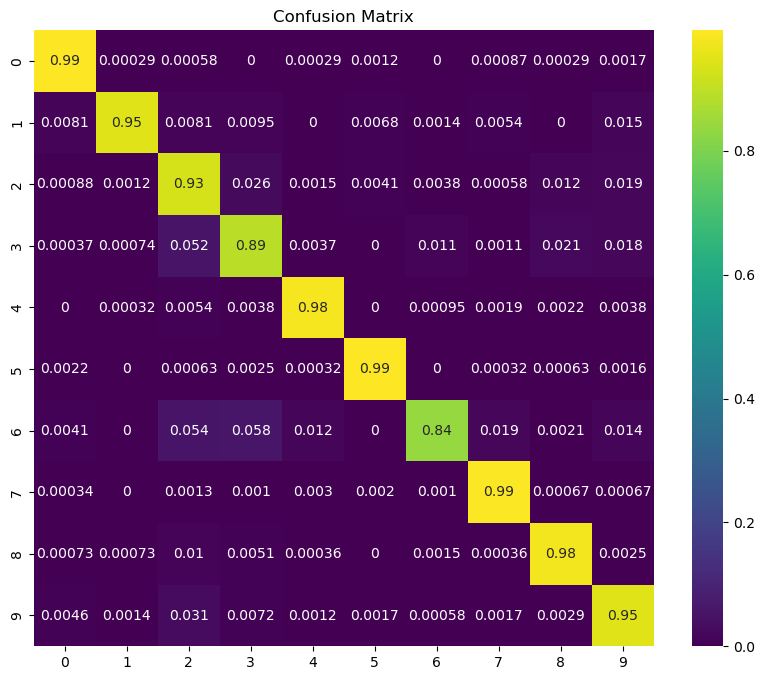

In [261]:
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(conf_mat_norm, index = labels,
                     columns = labels)

plt.figure(figsize = (10,8))
plt.title('Confusion Matrix')
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.show()

# load base model and re-evaluate

In [ ]:
model.load_weights(best_model_weights)

In [ ]:
# Re-evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# LSTM model

In [239]:
X_train_ = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_val_ = X_val.reshape(X_val.shape[0],X_val.shape[1],1)

In [264]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train_.shape[1], X_train_.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.3),   
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [265]:
lstm_model.summary()

Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 161, 128)          66560     
                                                                 
 dropout_98 (Dropout)        (None, 161, 128)          0         
                                                                 
 lstm_49 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_99 (Dropout)        (None, 128)               0         
                                                                 
 dense_163 (Dense)           (None, 10)                1290      
                                                                 
Total params: 199434 (779.04 KB)
Trainable params: 199434 (779.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [266]:
best_model_weights = './model_wt/lstm'

checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor = "val_loss",
    verbose = 1,
    save_best_only = True,
    mode = 'min',
    save_weights_only = False,
    save_freq='epoch'    
    )

callbacks = [checkpoint]

lstm_model.compile(optimizer = 'adam', #alternative "SGD"
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])         
    

In [ ]:
lstm_history = lstm_model.fit(X_train_, train_y, batch_size=num_batch_size, 
    epochs=num_epochs, validation_data=(X_val_, test_y), callbacks=[checkpoint])

Epoch 1/50
 6/11 [===============>..............] - ETA: 1:08 - loss: 2.2441 - accuracy: 0.2342

In [ ]:
loss, acc = lstm_model.evaluate(X_val_, test_y, verbose=2)
print("LSTM model, accuracy: {:5.2f}%".format(100 * acc))

In [ ]:
#model.predict_classes(X_test)
lstm_predict_val=lstm_model.predict(X_val_) 
lstm_classes_val=np.argmax(lstm_predict_val,axis=1)

In [ ]:
lstm_conf_mat = confusion_matrix(test_y, lstm_classes_val, labels=labels)
print("overall accuracy:", sum(lstm_conf_mat.diagonal())/sum(sum(lstm_conf_mat)))

In [ ]:
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(conf_mat_norm, index = labels,
                     columns = labels)

plt.figure(figsize = (10,8))
plt.title('Confusion Matrix')
sns.heatmap(df_cm, annot=True, cmap='viridis')
plt.show()

In [183]:
def LSTM_plus(N_CLASSES=10):
    
    input_shape = Input(shape=(10000, 161, 1))
    x = LayerNormalization(axis=2, name='batch_norm')(input_shape)
    x = TimeDistributed(layers.Reshape((-1,)), name='reshape')(x)
    s = TimeDistributed(layers.Dense(64, activation='tanh'),
                        name='td_dense_tanh')(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True),
                             name='bidirectional_lstm')(s)
    x = layers.concatenate([s, x], axis=2, name='skip_connection')
    x = layers.Dense(64, activation='relu', name='dense_1_relu')(x)
    x = layers.MaxPooling1D(name='max_pool_1d')(x)
    x = layers.Dense(32, activation='relu', name='dense_2_relu')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dropout(rate=0.2, name='dropout')(x)
    x = layers.Dense(32, activation='relu',
                         activity_regularizer=l2(0.001),
                         name='dense_3_relu')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)
    model = Model(inputs=i.input, outputs=o, name='long_short_term_memory')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [184]:
model = LSTM()

NameError: name 'Input' is not defined

In [173]:
sr=6000; dt=1.0

In [ ]:
tg = DataGenerator(wav_train, label_train, sr, dt,
                       params['N_CLASSES'], batch_size=batch_size)
vg = DataGenerator(wav_val, label_val, sr, dt,
                       params['N_CLASSES'], batch_size=batch_size)

In [182]:
cp = ModelCheckpoint('models/LSTM.h5', monitor='val_loss', save_best_only=True, save_weights_only=False,
                         mode='auto', save_freq='epoch', verbose=1)

csv_path = os.path.join('logs', 'LSTM_history.csv')

csv_logger = CSVLogger(csv_path, append=False)

model.fit((train_x, train_y), validation_data=(X_test, test_y),
              epochs=30, verbose=1,
              callbacks=[csv_logger, cp])

Train on 92017 samples, validate on 39436 samples
Epoch 1/30


2023-10-21 23:40:24.657709: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: JIT compilation failed.
2023-10-21 23:40:24.657755: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16396245321115503871
2023-10-21 23:40:24.657767: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8698323099035034918
2023-10-21 23:40:24.657777: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: JIT compilation failed.


UnknownError: 2 root error(s) found.
  (0) UNKNOWN: JIT compilation failed.
	 [[{{node training/Adam/Pow}}]]
	 [[metrics/accuracy/Identity/_93]]
  (1) UNKNOWN: JIT compilation failed.
	 [[{{node training/Adam/Pow}}]]
0 successful operations.
0 derived errors ignored.

In [153]:
def train(args):
    src_root = args.src_root
    sr = args.sample_rate
    dt = args.delta_time
    batch_size = args.batch_size
    model_type = args.model_type
    params = {'N_CLASSES':len(os.listdir(args.src_root)),
              'SR':sr,
              'DT':dt}
    models = {'conv1d':Conv1D(**params),
              'conv2d':Conv2D(**params),
              'lstm':  LSTM(**params)}
    assert model_type in models.keys(), '{} not an available model'.format(model_type)
    csv_path = os.path.join('logs', '{}_history.csv'.format(model_type))

    wav_paths = glob('{}/**'.format(src_root), recursive=True)
    wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x]
    classes = sorted(os.listdir(args.src_root))
    le = LabelEncoder()
    le.fit(classes)
    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
    labels = le.transform(labels)
    wav_train, wav_val, label_train, label_val = train_test_split(wav_paths,
                                                                  labels,
                                                                  test_size=0.1,
                                                                  random_state=0)

    assert len(label_train) >= args.batch_size, 'Number of train samples must be >= batch_size'
    if len(set(label_train)) != params['N_CLASSES']:
        warnings.warn('Found {}/{} classes in training data. Increase data size or change random_state.'.format(len(set(label_train)), params['N_CLASSES']))
    if len(set(label_val)) != params['N_CLASSES']:
        warnings.warn('Found {}/{} classes in validation data. Increase data size or change random_state.'.format(len(set(label_val)), params['N_CLASSES']))

    tg = DataGenerator(wav_train, label_train, sr, dt,
                       params['N_CLASSES'], batch_size=batch_size)
    vg = DataGenerator(wav_val, label_val, sr, dt,
                       params['N_CLASSES'], batch_size=batch_size)
    model = models[model_type]
    cp = ModelCheckpoint('models/{}.h5'.format(model_type), monitor='val_loss',
                         save_best_only=True, save_weights_only=False,
                         mode='auto', save_freq='epoch', verbose=1)
    csv_logger = CSVLogger(csv_path, append=False)
    model.fit(tg, validation_data=vg,
              epochs=30, verbose=1,
              callbacks=[csv_logger, cp])

In [124]:
n_splits=10
accuracies = []
kf = KFold(n_splits=10,random_state=1234, shuffle=True)

In [139]:
model = get_network()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               41472     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 83274 (325.29 KB)
Trainable params: 83274 (325.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [148]:
train_x.shape

(131453, 161)

In [149]:
labels.shape

(131453,)

In [147]:
kf = KFold(n_splits)
for i, (train_index, test_index) in enumerate(kf.split(train_x)):
    x_train_i = train_x[train_index]
    y_train_i = labels[train_index]
    
    x_test_i = train_x[test_index]
    y_test_i = labels[train_index]    
    
    
    model = get_network()
    model.fit(x_train_i, y_train_i, epochs = 50, batch_size = 10000, verbose = 0)
    
    # evaluate on test set/fold
    y_true, y_pred = [], []
    for x, y in zip(x_test_i, y_test_i):
        # average predictions over segments of a sound clip
        avg_p = np.argmax(np.mean(model.predict(x), axis = 0))
        y_pred.append(avg_p) 
        
        # pick single label via np.unique for a sound clip
        y_true.append(np.unique(y)[0]) 
    accuracies.append(accuracy_score(y_true, y_pred))    
print("Average 10 Folds Accuracy: {0}".format(np.mean(accuracies)))
 

2023-10-21 22:06:31.090600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-21 22:06:31.090915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-21 22:06:31.091092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

UnknownError: 2 root error(s) found.
  (0) UNKNOWN: JIT compilation failed.
	 [[{{node training/Adam/Pow}}]]
	 [[metrics/accuracy/Identity/_81]]
  (1) UNKNOWN: JIT compilation failed.
	 [[{{node training/Adam/Pow}}]]
0 successful operations.
0 derived errors ignored.